In [76]:
import sys
path = "/usr/local/lib/python3.9/dist-packages/liegroups-1.1.0-py3.9.egg"
if path not in sys.path:
    sys.path.append(path)
    
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import liegroups
import lietorch

from liegroups.torch import SE3
import torch

In [239]:
class Position3(object):
    def __init__(self, translation, rotation):
        self._rotation = rotation
        self._translation = translation
        
    @classmethod
    def from_vec(cls, vec):
        if len(vec.shape) == 1:
            translation = vec[:3]
            rotation = Rotation.from_euler('xyz', vec[3:], degrees=False)
        return cls(translation, rotation)
    
    def inv(self):
        rotation = self._rotation.inv()
        translation = -rotation.apply(self._translation)
        return Position3(translation, rotation)

    def __mul__(self, other):
        rotation = self._rotation * other._rotation
        translation = self._translation + self._rotation.apply(other._translation)
        return Position3(translation, rotation)
    
    def apply(self, points):
        return self._translation + self._rotation.apply(points)
    
    def as_matrix(self, full=True):
        if len(self._translation.shape) == 1:
            if full:
                result = np.zeros((4, 4))
                result[3, 3] = 1
            else:
                result = np.zeros((3, 4))
            result[:3, :3] = self._rotation.as_matrix()
            result[:3, 3] = self._translation
            return result
    
    def as_qvec(self):
        if len(self._translation.shape) == 1:
            result = np.zeros(7)
            result[:3] = self._translation
            result[3:] = self._rotation.as_quat()
            return result

    def as_se3(self):
        tensor = torch.tensor(self.as_matrix().astype(np.float32))[None]
        return SE3.from_matrix(tensor)
    
    def as_se3_torch(self, requires_grad=False):
        tensor = torch.tensor(self.as_qvec().astype(np.float32)[None], requires_grad=requires_grad)
#         tensor.retain_grad(True)
        return lietorch.SE3(tensor)

# Generate points

In [240]:
np.random.seed(100)
points = np.random.rand(10, 2) * 5
points = np.concatenate([points, np.zeros((10, 1))], axis=1)
points_tensor = torch.tensor(points.astype(np.float32))
points

array([[2.71702471, 1.39184693, 0.        ],
       [2.12258795, 4.22388066, 0.        ],
       [0.02359428, 0.6078456 , 0.        ],
       [3.35374542, 4.12926378, 0.        ],
       [0.68353295, 2.87546665, 0.        ],
       [4.45660977, 1.04601061, 0.        ],
       [0.9266411 , 0.54188445, 0.        ],
       [1.09848746, 4.89311892, 0.        ],
       [4.05841575, 0.85970506, 0.        ],
       [4.08112374, 1.37036874, 0.        ]])

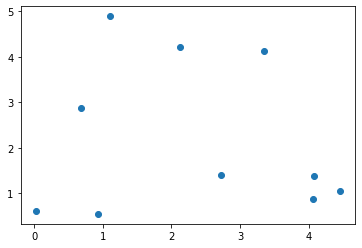

In [241]:
plt.scatter(points[:, 0], points[:, 1])

In [242]:
def matrix_from_position(position):
    result = np.zeros()

1.8364679025753081

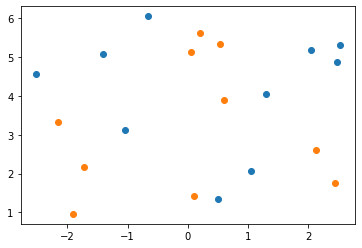

In [243]:
position1 = Position3.from_vec(np.array([1, 1, 0, 0, 0, 1]))
position2 = Position3.from_vec(np.array([3, 2, 0, 0, 0, 2]))
delta_position = position1 * position2.inv()

points1 = position1.apply(points)
points2 = position2.apply(points)
plt.scatter(points1[:, 0], points1[:, 1])
plt.scatter(points2[:, 0], points2[:, 1])
loss = np.mean((points1 - points2) ** 2)
loss

# Liegroups module

In [244]:
log_position1 = position1.as_se3().log()
log_position2 = position2.as_se3().log()
log_position1.requires_grad = True
points_tensor_hom = torch.ones(points_tensor.shape[0], 4)
points_tensor_hom[:, :3] = points_tensor
points1 = (points_tensor_hom @ SE3.exp(log_position1).as_matrix().T)[:, :3]
points2 = (points_tensor_hom @ SE3.exp(log_position2).as_matrix().T)[:, :3]
loss = torch.mean((points1 - points2) ** 2)
loss.backward()
loss

tensor(1.8365, grad_fn=<MeanBackward0>)

In [245]:
log_position1.grad

tensor([ 0.5113,  0.4045,  0.0000,  0.0000,  0.0000, -3.8233])

# Lietorch module

In [246]:
log_position1 = position1.as_se3_torch(False).log()
log_position1.requires_grad = True
points1 = lietorch.SE3.exp(log_position1).act(points_tensor)
points2 = position2.as_se3_torch(False).act(points_tensor)
loss = torch.mean((points1 - points2) ** 2)
loss.backward()
loss

tensor(1.8365, grad_fn=<MeanBackward0>)

In [247]:
log_position1.grad

tensor([[ 0.5113,  0.4045,  0.0000,  0.0000,  0.0000, -3.8233]])

In [250]:
lie_position1 = position1.as_se3_torch(True)
# lie_position1.data.retain_grad()
# log_position1.requires_grad = True
points1 = lie_position1.act(points_tensor)
points2 = position2.as_se3_torch(False).act(points_tensor)
loss = torch.mean((points1 - points2) ** 2)
loss.backward()
loss

tensor(1.8365, grad_fn=<MeanBackward0>)

In [251]:
lie_position1.data.grad

tensor([[ 0.2657,  0.6259,  0.0000,  0.0000,  0.0000, -3.5676,  0.0000]])

In [253]:
lie_position1 * lie_position1

SE3: size=torch.Size([1]), device=cpu, dtype=torch.float32

In [254]:
?torch.autograd.grad

In [257]:
torch.autograd.grad(lie_position1, lie_position1)

AttributeError: 'SE3' object has no attribute 'requires_grad'